## Add Starting Pitching to Model
- In the last notebook we augmented our dataframe to include various features based on the starting pitcher's performance
- Now we will add these features in to see how much improvement we get to our model.
- NOTE: have modified the previous notebook (added "Strt_" to feature names)

In [1]:
# Uncomment if you need to install any of the following packages
# !pip install lightgbm
# !pip install ml_insights --upgrade
# !pip install structureboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [3]:
df=pd.read_csv('df_bp5.csv')

/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (13,14,15,19,85,87,206) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Begin Modeling

In [4]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1980) & (df.season<=2018)]
df_valid = df[(df.season>=2019) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [5]:
hv_mean = df_train.home_victory.mean()

## First - just add in ERA and WHIP over last 35 games

In [6]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v', 
]
target = 'home_victory'

In [7]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [8]:
X_train.shape, X_valid.shape, X_test.shape, 

((85933, 8), (3327, 8), (4852, 8))

In [9]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.688975
[20]	valid_0's binary_logloss: 0.687769
[30]	valid_0's binary_logloss: 0.686855
[40]	valid_0's binary_logloss: 0.686084
[50]	valid_0's binary_logloss: 0.685126
[60]	valid_0's binary_logloss: 0.684286
[70]	valid_0's binary_logloss: 0.683621
[80]	valid_0's binary_logloss: 0.682937
[90]	valid_0's binary_logloss: 0.682296
[100]	valid_0's binary_logloss: 0.681724
[110]	valid_0's binary_logloss: 0.681264
[120]	valid_0's binary_logloss: 0.680795
[130]	valid_0's binary_logloss: 0.680343
[140]	valid_0's binary_logloss: 0.679947
[150]	valid_0's binary_logloss: 0.679555
[160]	valid_0's binary_logloss: 0.679293
[170]	valid_0's binary_logloss: 0.679009
[180]	valid_0's binary_logloss: 0.678808
[190]	valid_0's binary_logloss: 0.678539
[200]	valid_0's binary_logloss: 0.678311
[210]	valid_0's binary_logloss: 0.678062
[220]	valid_0's binary_logloss: 0.677894
[230]	valid_0's binary_logloss: 0.677667
[240]

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [10]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [11]:
# previous model gave 0.6830
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6747220008304048, 0.6904929601621782)

In [12]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6675629431340582

In [13]:
np.round([.6904 - .6675, .6904-.6830, .6904-.6747], decimals=4)

array([0.0229, 0.0074, 0.0157])

In [14]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

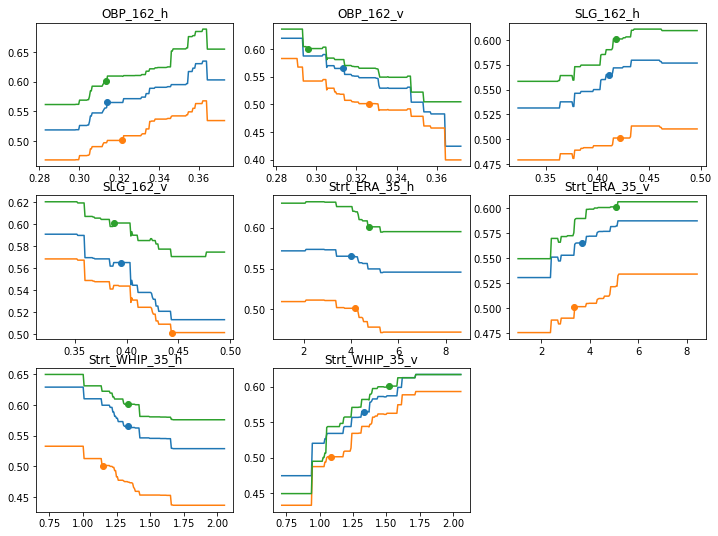

In [15]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

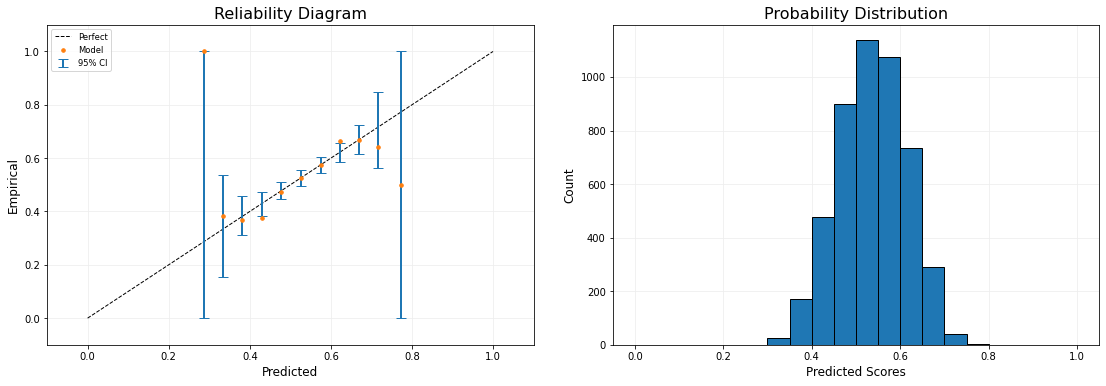

In [16]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [17]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [18]:
# This shows for each game, how the different features affected 
sv_lgbm.head(5).round(3)

,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,Strt_ERA_35_h,Strt_ERA_35_v,Strt_WHIP_35_h,Strt_WHIP_35_v,Intercept
0,-0.079,0.073,0.056,0.036,0.059,0.012,0.143,0.076,0.157
1,-0.079,0.053,0.046,0.035,0.035,-0.075,0.101,-0.220,0.157
2,-0.027,0.007,0.076,-0.112,-0.076,-0.098,0.046,-0.224,0.157
3,-0.169,0.011,-0.028,-0.041,0.031,-0.079,0.028,-0.188,0.157
4,-0.054,0.006,0.028,-0.105,0.028,-0.026,0.029,-0.530,0.157


In [19]:
df_test.pitcher_start_name_v.iloc[4]

'Kenta Maeda'

In [20]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept         0.157220
Strt_WHIP_35_v    0.092759
Strt_WHIP_35_h    0.085960
OBP_162_v         0.077186
OBP_162_h         0.073883
Strt_ERA_35_h     0.048258
SLG_162_h         0.044555
SLG_162_v         0.043457
Strt_ERA_35_v     0.040790
dtype: float64

## Let's add in a few more pitching features

In [21]:
# Add in SO% and "Modified Slugging Against"
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
]
target = 'home_victory'

In [22]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [23]:
X_train.shape, X_valid.shape, X_test.shape, 

((85933, 14), (3327, 14), (4852, 14))

In [24]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.688888
[20]	valid_0's binary_logloss: 0.687733
[30]	valid_0's binary_logloss: 0.686833
[40]	valid_0's binary_logloss: 0.685775
[50]	valid_0's binary_logloss: 0.684702
[60]	valid_0's binary_logloss: 0.683783
[70]	valid_0's binary_logloss: 0.682864
[80]	valid_0's binary_logloss: 0.682001
[90]	valid_0's binary_logloss: 0.681393
[100]	valid_0's binary_logloss: 0.68074
[110]	valid_0's binary_logloss: 0.680269
[120]	valid_0's binary_logloss: 0.679861
[130]	valid_0's binary_logloss: 0.679402
[140]	valid_0's binary_logloss: 0.679024
[150]	valid_0's binary_logloss: 0.678649
[160]	valid_0's binary_logloss: 0.678317
[170]	valid_0's binary_logloss: 0.677921
[180]	valid_0's binary_logloss: 0.677676
[190]	valid_0's binary_logloss: 0.677543
[200]	valid_0's binary_logloss: 0.67731
[210]	valid_0's binary_logloss: 0.677077
[220]	valid_0's binary_logloss: 0.677012
[230]	valid_0's binary_logloss: 0.676828
[240]	v

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [25]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [26]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.674987545582293, 0.6904929601621782)

In [27]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

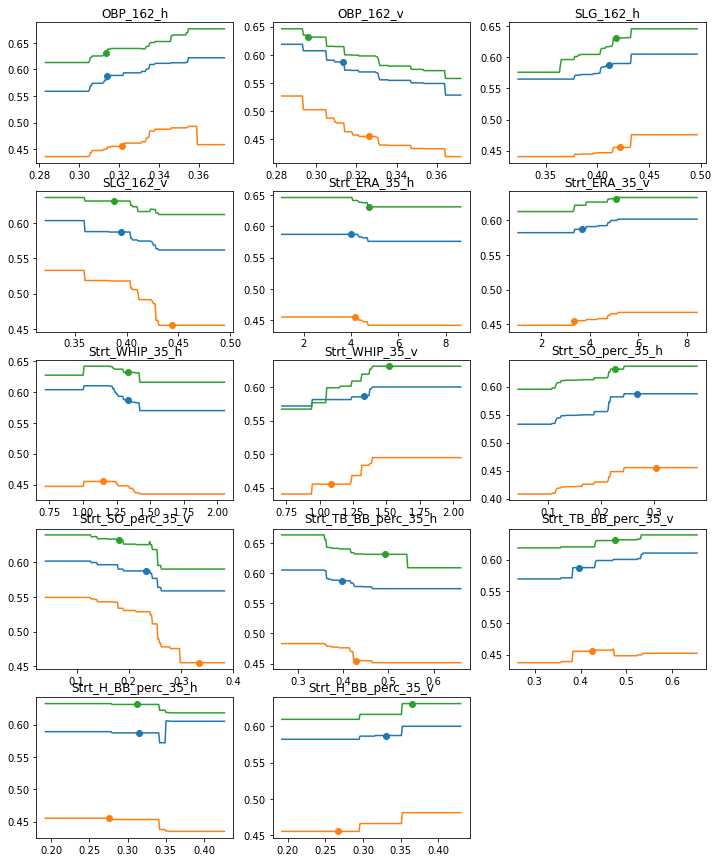

In [28]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

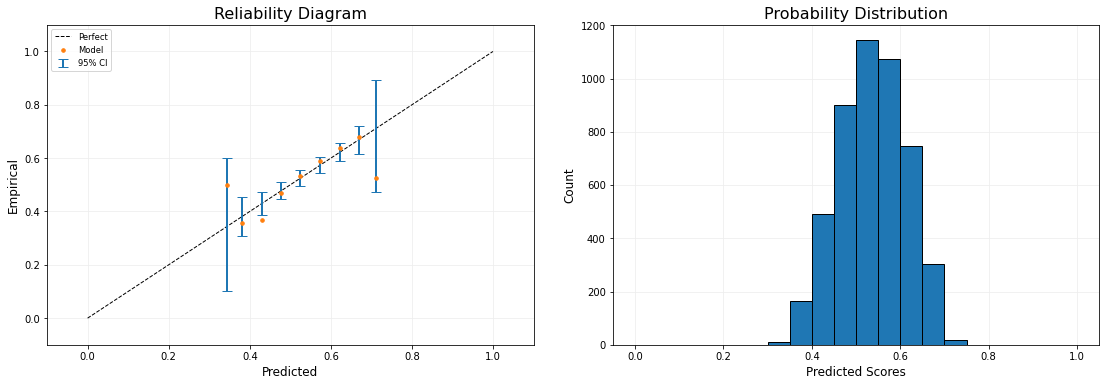

In [29]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [30]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [31]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.156905
Strt_SO_perc_35_v       0.084315
Strt_SO_perc_35_h       0.071734
OBP_162_v               0.067599
OBP_162_h               0.056671
Strt_WHIP_35_v          0.050667
Strt_WHIP_35_h          0.046770
SLG_162_h               0.041868
Strt_TB_BB_perc_35_h    0.036163
SLG_162_v               0.034773
Strt_H_BB_perc_35_v     0.020719
Strt_ERA_35_v           0.020455
Strt_ERA_35_h           0.019549
Strt_TB_BB_perc_35_v    0.017436
Strt_H_BB_perc_35_h     0.014587
dtype: float64

In [32]:
## Let's add in the 10 game lookback features
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_ERA_10_h','Strt_ERA_10_v',
            'Strt_WHIP_10_h','Strt_WHIP_10_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Strt_TB_BB_perc_10_h', 'Strt_TB_BB_perc_10_v',
]
target = 'home_victory'

In [33]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [34]:
X_train.shape, X_valid.shape, X_test.shape, 

((85933, 20), (3327, 20), (4852, 20))

In [35]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.688888
[20]	valid_0's binary_logloss: 0.687744
[30]	valid_0's binary_logloss: 0.686825
[40]	valid_0's binary_logloss: 0.685676
[50]	valid_0's binary_logloss: 0.684757
[60]	valid_0's binary_logloss: 0.683896
[70]	valid_0's binary_logloss: 0.682991
[80]	valid_0's binary_logloss: 0.682292
[90]	valid_0's binary_logloss: 0.68174
[100]	valid_0's binary_logloss: 0.681131
[110]	valid_0's binary_logloss: 0.680548
[120]	valid_0's binary_logloss: 0.680048
[130]	valid_0's binary_logloss: 0.679609
[140]	valid_0's binary_logloss: 0.679092
[150]	valid_0's binary_logloss: 0.678684
[160]	valid_0's binary_logloss: 0.678307
[170]	valid_0's binary_logloss: 0.677937
[180]	valid_0's binary_logloss: 0.677669
[190]	valid_0's binary_logloss: 0.677382
[200]	valid_0's binary_logloss: 0.677131
[210]	valid_0's binary_logloss: 0.676814
[220]	valid_0's binary_logloss: 0.676605
[230]	valid_0's binary_logloss: 0.676397
[240]	

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [36]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [37]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6748118015338063, 0.6904929601621782)

In [38]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

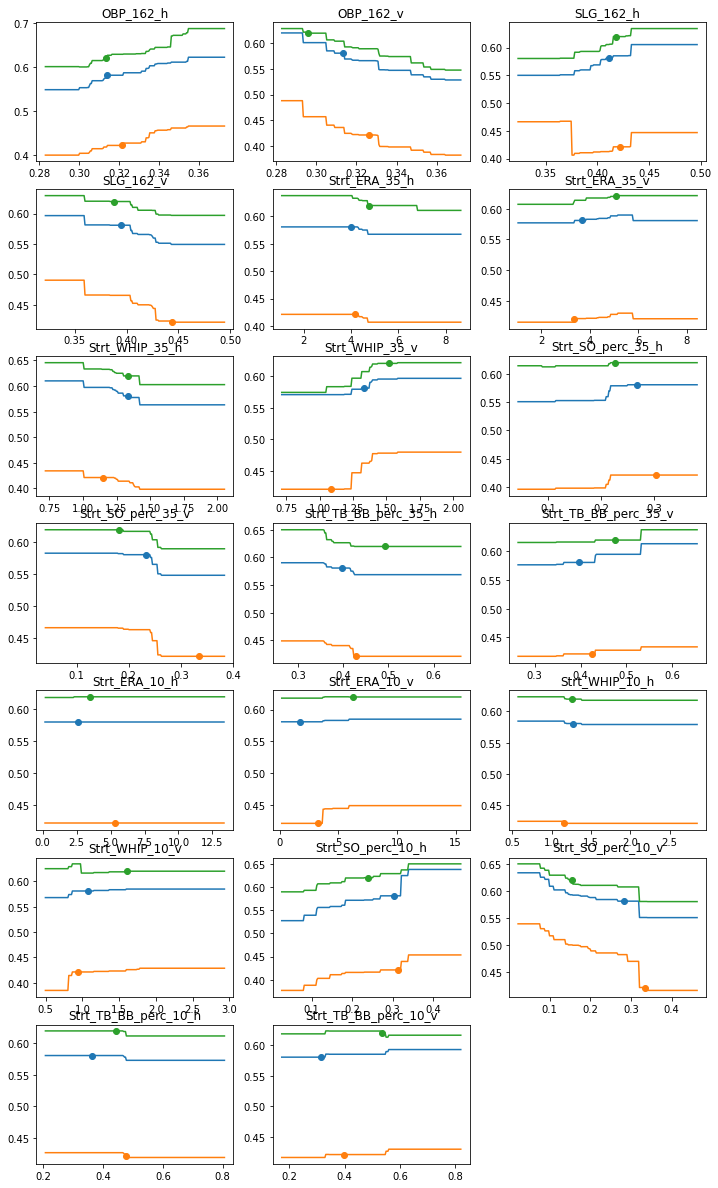

In [39]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

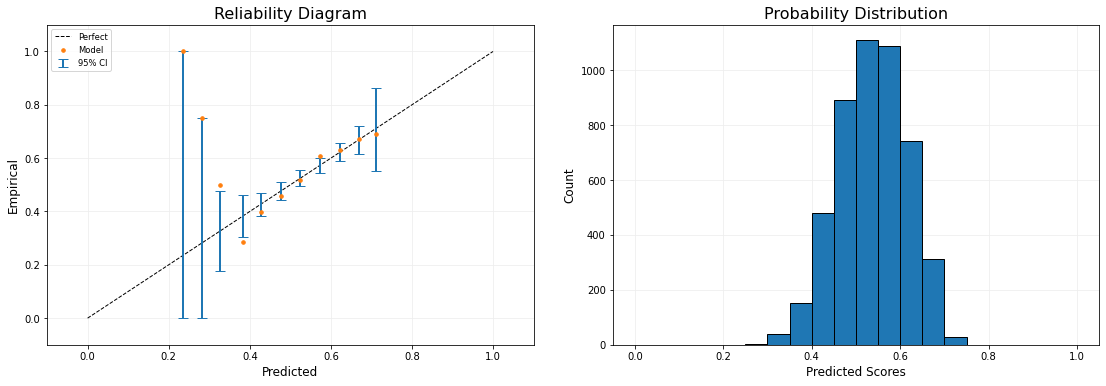

In [40]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [41]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [42]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.157151
OBP_162_v               0.068841
OBP_162_h               0.061437
Strt_WHIP_35_v          0.059590
Strt_SO_perc_10_v       0.055916
Strt_SO_perc_10_h       0.053644
Strt_WHIP_35_h          0.046413
SLG_162_h               0.043847
Strt_SO_perc_35_v       0.039195
Strt_SO_perc_35_h       0.035598
SLG_162_v               0.034940
Strt_TB_BB_perc_35_h    0.028470
Strt_ERA_35_h           0.022081
Strt_TB_BB_perc_35_v    0.015991
Strt_ERA_35_v           0.015178
Strt_ERA_10_v           0.014622
Strt_TB_BB_perc_10_h    0.014202
Strt_WHIP_10_h          0.010703
Strt_WHIP_10_v          0.007033
Strt_TB_BB_perc_10_v    0.004523
Strt_ERA_10_h           0.000287
dtype: float64

In [43]:
# Choose the best window size for each metric, drop ERA
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            
]
target = 'home_victory'

In [44]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [45]:
X_train.shape, X_valid.shape, X_test.shape, 

((85933, 10), (3327, 10), (4852, 10))

In [46]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.688866
[20]	valid_0's binary_logloss: 0.687717
[30]	valid_0's binary_logloss: 0.686827
[40]	valid_0's binary_logloss: 0.68605
[50]	valid_0's binary_logloss: 0.685209
[60]	valid_0's binary_logloss: 0.68441
[70]	valid_0's binary_logloss: 0.683598
[80]	valid_0's binary_logloss: 0.682848
[90]	valid_0's binary_logloss: 0.682167
[100]	valid_0's binary_logloss: 0.681659
[110]	valid_0's binary_logloss: 0.681072
[120]	valid_0's binary_logloss: 0.680481
[130]	valid_0's binary_logloss: 0.679909
[140]	valid_0's binary_logloss: 0.679469
[150]	valid_0's binary_logloss: 0.679086
[160]	valid_0's binary_logloss: 0.678744
[170]	valid_0's binary_logloss: 0.678455
[180]	valid_0's binary_logloss: 0.678197
[190]	valid_0's binary_logloss: 0.677867
[200]	valid_0's binary_logloss: 0.677601
[210]	valid_0's binary_logloss: 0.677419
[220]	valid_0's binary_logloss: 0.677165
[230]	valid_0's binary_logloss: 0.677001
[240]	v

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [47]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [48]:
# now about 4 bps worse than previous model..
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6749901646725965, 0.6904929601621782)

In [49]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6675629431340582

In [50]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

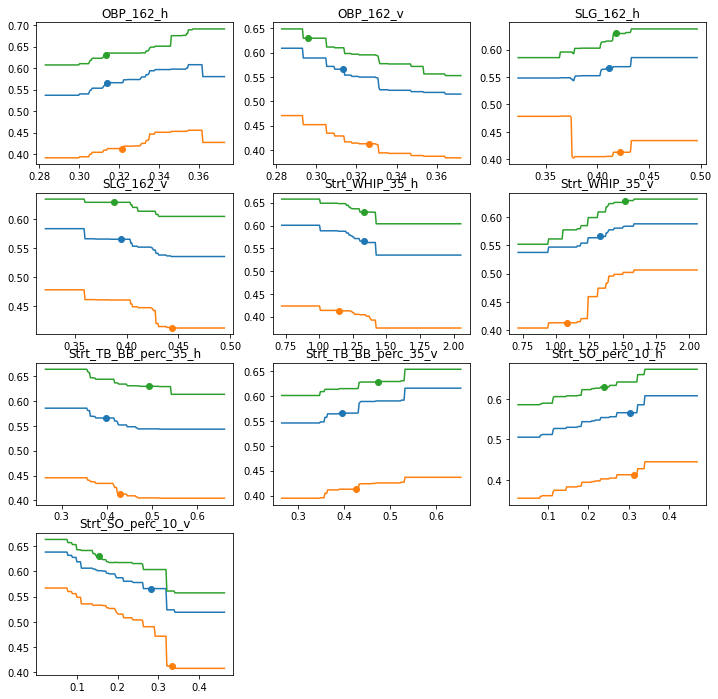

In [51]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

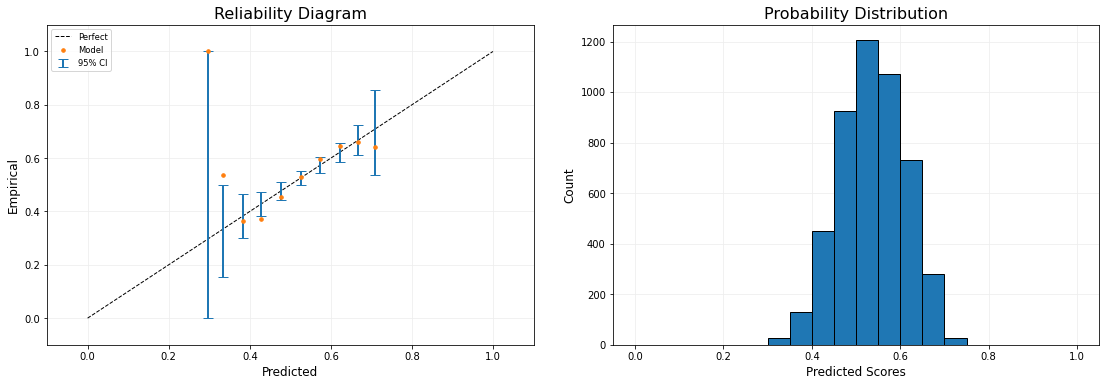

In [52]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [53]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [54]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.157073
Strt_SO_perc_10_v       0.082279
Strt_SO_perc_10_h       0.078344
Strt_WHIP_35_v          0.077848
OBP_162_v               0.068678
Strt_WHIP_35_h          0.066446
OBP_162_h               0.061356
SLG_162_h               0.041615
Strt_TB_BB_perc_35_h    0.040650
SLG_162_v               0.035725
Strt_TB_BB_perc_35_v    0.031188
dtype: float64

## How much do these differences in log loss really mean?
When model A does a few bps better than model B in log loss,  how should we think about that?
- Is it a meaningful improvement?
- How do we know it is not just "luck of the draw" of the test set

We'll run some quick simulations to build our intuition about this.

In [56]:
# Simulate a test set (with given "true" probabilities) and compare two models, 
def ll_dist(probvec_true, probvec_mod1, probvec_mod2, num_trials):
    llvec_mod1 = np.zeros(num_trials)
    llvec_mod2 = np.zeros(num_trials)
    for i in range(num_trials):
        sim_outcome = np.random.binomial(n=1, p=probvec_true)
        llvec_mod1[i] = log_loss(sim_outcome, probvec_mod1)
        llvec_mod2[i] = log_loss(sim_outcome, probvec_mod2)
    return(llvec_mod1 - llvec_mod2)

In [57]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)

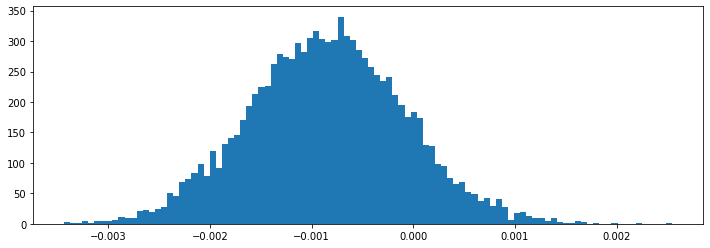

In [58]:
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

In [59]:
pv_true = np.repeat(df_test.implied_prob_h_mid,10)
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)

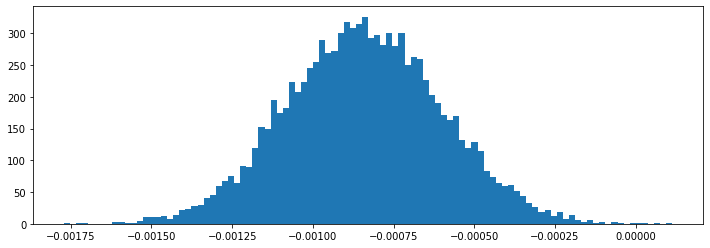

In [60]:
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

In [61]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.10, .10, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)

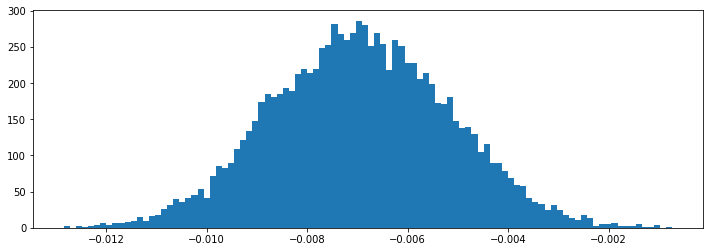

In [62]:
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

# Conclusions
- ## Could be that 5-10 bps improvement is meaningful!
- ## Variation due to test set size is considerable
- ## Not a simple matter to increase test set size in this problem
- ## For now, still need to improve beyond minor optimizations

# Next Steps
- ## Have nothing about the quality of the bullpen
- ## Bullpen is more meaningful in recent years, as starting pitchers work fewer innings
- ## Could cause an issue with "model drift" - something to explore later on

- ## We don't account for the specific hitting lineup - would need individual batter data

- ## We have nothing about fielding

- ## Several additional sources of model drift
    - ## Rule changes about infield positioning
    - ## Pitching clock
    - ## NL now has a DH